<a href="https://colab.research.google.com/github/TrzeciakPiotr2300/Uczenie_Maszynowe_2025/blob/main/trees_excercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Tree excercises**


In [14]:
from sklearn.datasets import (
    make_classification, make_regression,
    load_iris, load_breast_cancer, load_wine,
    fetch_california_housing, load_diabetes
)
from sklearn.model_selection import train_test_split
import pandas as pd

datasets = []

# --- 3 synthetic classification datasets ---
for i in range(3):
    X, y = make_classification(n_samples=1000, n_features=10,
                               n_informative=6, n_redundant=2,
                               n_classes=2, random_state=i)
    X = pd.DataFrame(X, columns=[f"feature_{j}" for j in range(X.shape[1])])
    y = pd.Series(y, name="target")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    datasets.append({
        "name": f"synthetic_classification_{i + 1}",
        "type": "classification",
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test
    })

# --- 2 synthetic regression datasets ---
for i in range(2):
    X, y = make_regression(n_samples=1000, n_features=10,
                           n_informative=8, noise=0.3, random_state=i)
    X = pd.DataFrame(X, columns=[f"feature_{j}" for j in range(X.shape[1])])
    y = pd.Series(y, name="target")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    datasets.append({
        "name": f"synthetic_regression_{i + 1}",
        "type": "regression",
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test
    })

# --- 5 real-world datasets from sklearn ---
def load_sklearn_dataset(loader_func, name, type_):
    raw = loader_func()
    X = pd.DataFrame(raw.data, columns=raw.feature_names)
    y = pd.Series(raw.target, name="target")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    return {
        "name": name,
        "type": type_,
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test
    }

datasets.append(load_sklearn_dataset(load_iris, "iris", "classification"))
datasets.append(load_sklearn_dataset(load_breast_cancer, "breast_cancer", "classification"))
datasets.append(load_sklearn_dataset(load_wine, "wine", "classification"))
datasets.append(load_sklearn_dataset(fetch_california_housing, "california_housing", "regression"))
datasets.append(load_sklearn_dataset(load_diabetes, "diabetes", "regression"))

# --- summary of datasets ---
print(f"Loaded {len(datasets)} datasets.")
for d in datasets:
    print(f"{d['name']} ({d['type']}) -> X_train: {d['X_train'].shape}, y_train: {d['y_train'].shape}")
print("Test size = 0.3")

# Example usage:
# model.fit(datasets[0]['X_train'], datasets[0]['y_train'])


Loaded 10 datasets.
synthetic_classification_1 (classification) -> X_train: (700, 10), y_train: (700,)
synthetic_classification_2 (classification) -> X_train: (700, 10), y_train: (700,)
synthetic_classification_3 (classification) -> X_train: (700, 10), y_train: (700,)
synthetic_regression_1 (regression) -> X_train: (700, 10), y_train: (700,)
synthetic_regression_2 (regression) -> X_train: (700, 10), y_train: (700,)
iris (classification) -> X_train: (105, 4), y_train: (105,)
breast_cancer (classification) -> X_train: (398, 30), y_train: (398,)
wine (classification) -> X_train: (124, 13), y_train: (124,)
california_housing (regression) -> X_train: (14448, 8), y_train: (14448,)
diabetes (regression) -> X_train: (309, 10), y_train: (309,)
Test size = 0.3


Criterior method: Accuracy

### ***Trees using GreadSearchCV*** (with .png saving)

In [15]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, r2_score
import matplotlib.pyplot as plt
import numpy as np
import warnings
import os

warnings.filterwarnings("ignore")

# Create folder for saving plots
os.makedirs("trees", exist_ok=True)

accuracy_scores = []

for d in datasets:
    print(f"Processing {d['name']}...")

    # Fit a full tree to get the pruning path
    if d['type'] == 'classification':
        full_tree = DecisionTreeClassifier(criterion='gini', random_state=42)
    else:
        full_tree = DecisionTreeRegressor(criterion='squared_error', random_state=42)

    full_tree.fit(d['X_train'], d['y_train'])
    path = full_tree.cost_complexity_pruning_path(d['X_train'], d['y_train'])
    ccp_alphas = path.ccp_alphas

    # Reduce the number of ccp_alpha values by selecting a smaller range (step size of 2.0)
    ccp_alphas_sampled = np.unique(np.round(ccp_alphas, 5))
    ccp_alphas_reduced = np.arange(ccp_alphas_sampled.min(), ccp_alphas_sampled.max(), 2.0)  # Step size of 2.0

    # Define hyperparameter grid
    param_grid = {
        'ccp_alpha': ccp_alphas_reduced,  # Reduced ccp_alpha values
        'max_depth': [3, 4, 5]  # Limiting max_depth to some reasonable values
    }

    # Select estimator and scoring based on task type
    if d['type'] == 'classification':
        estimator = DecisionTreeClassifier(criterion='gini', random_state=42, min_samples_leaf=5)
        scoring = 'accuracy'
    else:
        estimator = DecisionTreeRegressor(criterion='squared_error', random_state=42, min_samples_leaf=5)
        scoring = 'r2'

    # Grid search with 3-fold CV (to speed things up)
    grid_search = GridSearchCV(estimator, param_grid, cv=3, scoring=scoring, n_jobs=-1)  # Use all CPU cores for speed
    grid_search.fit(d['X_train'], d['y_train'])

    # Train the best estimator on the full training set
    best_model = grid_search.best_estimator_
    best_model.fit(d['X_train'], d['y_train'])

    # Predict on test set
    y_pred = best_model.predict(d['X_test'])
    if d['type'] == 'classification':
        score = accuracy_score(d['y_test'], y_pred)
    else:
        score = r2_score(d['y_test'], y_pred)

    accuracy_scores.append(score)

    # Show summary
    print(f"{d['name']} | Type: {d['type']} | Best Params: {grid_search.best_params_} | Score: {score:.4f}")

    # Plot and save tree
    plt.figure(figsize=(20, 10))
    plot_tree(best_model, filled=True, feature_names=d['X_train'].columns)
    plt.title(f"{d['name']} - Decision Tree")
    plt.savefig(f"trees/{d['name'].replace(' ', '_').lower()}_tree.png")
    plt.close()


Processing synthetic_classification_1...
synthetic_classification_1 | Type: classification | Best Params: {'ccp_alpha': np.float64(0.0), 'max_depth': 4} | Score: 0.8700
Processing synthetic_classification_2...
synthetic_classification_2 | Type: classification | Best Params: {'ccp_alpha': np.float64(0.0), 'max_depth': 4} | Score: 0.8467
Processing synthetic_classification_3...
synthetic_classification_3 | Type: classification | Best Params: {'ccp_alpha': np.float64(0.0), 'max_depth': 4} | Score: 0.8167
Processing synthetic_regression_1...
synthetic_regression_1 | Type: regression | Best Params: {'ccp_alpha': np.float64(236.0), 'max_depth': 5} | Score: 0.4103
Processing synthetic_regression_2...
synthetic_regression_2 | Type: regression | Best Params: {'ccp_alpha': np.float64(118.0), 'max_depth': 5} | Score: 0.6965
Processing iris...
iris | Type: classification | Best Params: {'ccp_alpha': np.float64(0.0), 'max_depth': 3} | Score: 1.0000
Processing breast_cancer...
breast_cancer | Type: 

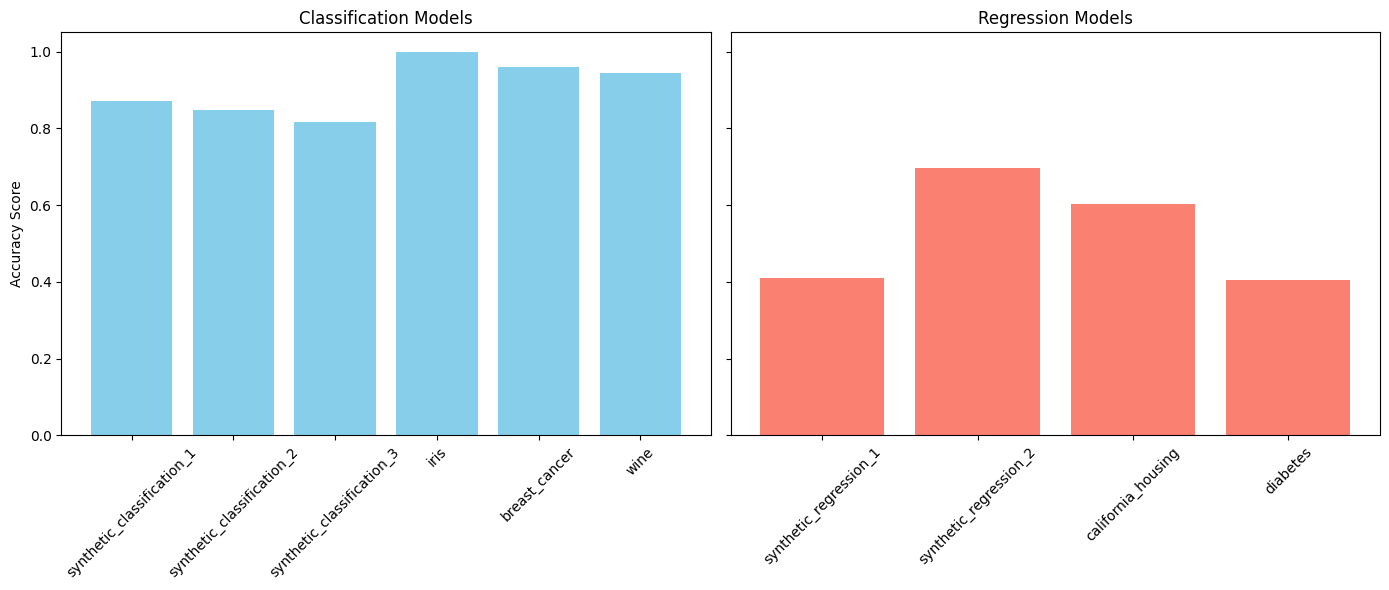

In [42]:
df = pd.DataFrame(datasets)
df = df.drop(index=10)
df['accuracy_scores'] = accuracy_scores
df = df[['name', 'type', 'accuracy_scores']]

class_df = df[df['type'] == 'classification']
reg_df = df[df['type'] == 'regression']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Classification
ax1.bar(class_df['name'], class_df['accuracy_scores'], color='skyblue')
ax1.set_title('Classification Models')
ax1.set_xticklabels(class_df['name'], rotation=45)
ax1.set_ylabel('Accuracy Score')

# Regression
ax2.bar(reg_df['name'], reg_df['accuracy_scores'], color='salmon')
ax2.set_title('Regression Models')
ax2.set_xticklabels(reg_df['name'], rotation=45)

plt.tight_layout()
plt.show()
